<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 2.2 Modelos deterministas de segundo orden </h3>
<h3 style="text-align: center;"> Ejercicios propuestos </h3>

## Ejercicio 1

El siguiente modelo propone representar el proceso de regulación de la glucosa en sangre a través de la producción de insulina. Para ello seguiremos el denominado **modelo mínimo** (más detalles en [Bergman et al, 2006](https://journals.physiology.org/doi/abs/10.1152/ajpendo.1979.236.6.E667), modelo VI), que asume dos hipótesis:

1. La glucosa, una vez introducida en sangre, vuelve a sus niveles basales debido a dos efectos: reducción natural de la concentración de glucosa y el efecto de la insulina.
2. La insulina no actúa directamente, sino que primero se desplaza de la sangre al fluido que rodea al tejido celular y de ahí actúa sobre la glucosa.

El modelo mínimo consiste en dos ecuaciones diferenciales:

$$\begin{array}{l}\displaystyle{\dot{G}} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t),\\
\displaystyle{\dot{X}} = k_3 \left[I(t) - I_b \right] - k_2 X(t),\end{array}$$ 

donde $G$ y $X$ son las concentraciones de glucosa en sangre y de insulina en el fluido del tejido celular, respectivamente. La función $I(t)$ indica la concentración de insulina en sangre, que tomamos exógena. Los parámetros $G_b$ e $I_b$ son los niveles basales de glucosa e insulina en sangre, mientras que $k_1$, $k_2$ y $k_3$ son parámetros positivos que controlan las tasas de decaemiento de glucosa e insulina. Los datos que se encuentran en este [archivo](https://github.com/AllenDowney/ModSim/raw/main/data/glucose\_insulin.csv) indican la concentración en sangre de glucosa e insulina medidos durante 182 minutos a un paciente normal.

**(a)** Estimar la concentración de glucosa en sangre a través del modelo.  En la simulación tomar como datos iniciales $k_1 = 0.02$,  $k_2 = 0.02$, $k_3 = 1.5e-05$, y unos niveles iniciales $G_0=270$ y $X_0=0$. Los niveles basales de glucosa e insulina en sangre son los iniciales de los datos reales. En la simulación es necesario interpolar los datos reales de concentración de insulina para cada minuto.

**(b)** Hallar los valores de los parámetros $k_1$, $k_2$ y $k_3$ con los que se obtenga el mejor ajuste de la simulación de la concentración de glucosa en sangre a los datos reales. Para el ajuste tomar los datos a partir de la cuarta toma de glucosa.

**(c)** Realmente la producción de insulina es endógena al sistema, y se propone que sigue la siguiente ecuación: 

$$ \dot{I} = -k I + \gamma (G - G_T) t, $$

siendo $k$, $\gamma$ y $G_T$ parámetros del modelo. Obsérvese que el incremento del la insulina depende del tiempo, indicando una sensibilidad creciente de la glucosa en la producción de insulina con el tiempo. Simular el nuevo modelo con valores iniciales de $k = 0.25$, $\gamma = 0.004$ y $G_T = 80$, con unos niveles de insulina iniciales de $I_0=360$. Ajustar estos parámetros de forma que se represente lo mejor posible los datos reales a partir de la cuarta toma.     

**(d)** Existen dos medidas biológicas que se construyen a partir de los parámetros del modelo:

$$ \begin{array}{l}\phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)},\\
    \phi_2 = \gamma \times 10^4.\end{array} $$
   
Según algunos autores, los valores esperados de estos parámetros están entre 2 y 4 para $\phi_1$ y 20 y 35 para $\phi_2$. Comprobar si con el ajuste realizado los valores de estas medidas están en los rangos esperados.  


#### Apartado a)

#### Parámetros del Modelo

- **k1**: Tasa de eliminación de glucosa independiente de la insulina. Se ha fijado en `0.02 min⁻¹`.
- **k2**: Tasa de eliminación de la insulina del compartimento extracelular. Se ha fijado en `0.02 min⁻¹`.
- **k3**: Sensibilidad de la glucosa a la insulina. Se ha fijado en `1.5e-5 min⁻²`.
- **Gb**: Nivel basal de glucosa en sangre, que se obtiene de los datos reales de glucosa. Es el valor inicial de la concentración de glucosa.
- **Ib**: Nivel basal de insulina en sangre, también tomado de los datos reales.
- **G0**: Concentración inicial de glucosa en sangre, en este caso `270 mg/dL`.
- **X0**: Concentración inicial de insulina en el fluido extracelular, fijada en `0`.

El modelo tiene como objetivo capturar la dinámica de la glucosa en función de la insulina y sus interacciones. A través de la interpolación de los datos de insulina y la resolución del sistema con el método de Euler, logramos una aproximación que sigue el comportamiento de los datos reales de glucosa, aunque con algunas desviaciones debido a la simplicidad del modelo.


In [1]:
import pandas as pd

file_path = 'glucose_insulin.csv'
data = pd.read_csv(file_path)

time = data['time'].values  # Tiempo en minutos
insulin_data = data['insulin'].values  # Concentración de insulina en sangre
glucose_data = data['glucose'].values  # Concentración de glucosa en sangre


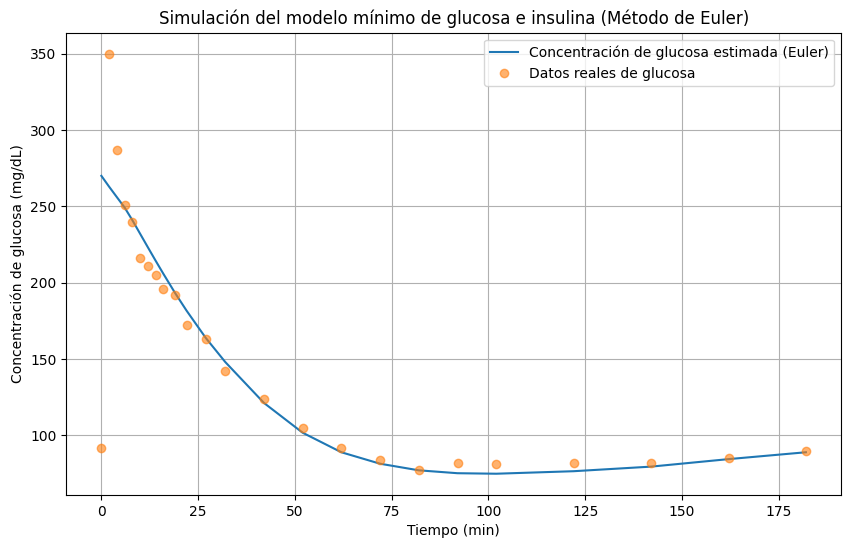

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes dadas nuevamente
k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
Gb = glucose_data[0] # Nivel basal de glucosa
Ib = insulin_data[0]  # Nivel basal de insulina

# Condiciones iniciales
G0 = 270  # Concentración inicial de glucosa
X0 = 0    # Concentración inicial de insulina en el fluido extracelular

# Interpolar la concentración de insulina para cada minuto
I_interpolated = np.interp(time, time, insulin_data)

# Definir la función de Euler para resolver las ODEs
def solveODE_euler(f, x0, t, I_interpolated, arg=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(x[i], t[i], I_interpolated[i], *arg)
    return x

# Definir la función que representa el sistema de ecuaciones diferenciales
def sys(y, t, I, k1, k2, k3, Gb, Ib):
    G, X = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    return np.array([dGdt, dXdt])

# Condiciones iniciales y constantes
y0 = [G0, X0]

# Resolver las ecuaciones utilizando el método de Euler
solution_euler = solveODE_euler(sys, y0, time, I_interpolated, (k1, k2, k3, Gb, Ib))

# Extraer la solución de la glucosa
G_solution_euler = solution_euler[:, 0]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_euler, label='Concentración de glucosa estimada (Euler)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de glucosa (mg/dL)')
plt.title('Simulación del modelo mínimo de glucosa e insulina (Método de Euler)')
plt.legend()
plt.grid(True)
plt.show()

#### Apartado b)

##### Ajuste de los parámetros del modelo 

En este apartado, realizaremos un ajuste de los parámetros del modelo para obtener los valores de **k1**, **k2**, y **k3** que proporcionen el mejor ajuste de la simulación a los datos reales de glucosa.

Los parámetros **k1**, **k2** y **k3** deben ajustarse para minimizar la diferencia entre los datos simulados y los datos reales a partir de la cuarta medición de glucosa. En lugar de utilizar valores fijos como en el apartado anterior, estos parámetros serán ajustados automáticamente mediante una función de coste para proporcionar una mejor precisión en el ajuste del modelo.

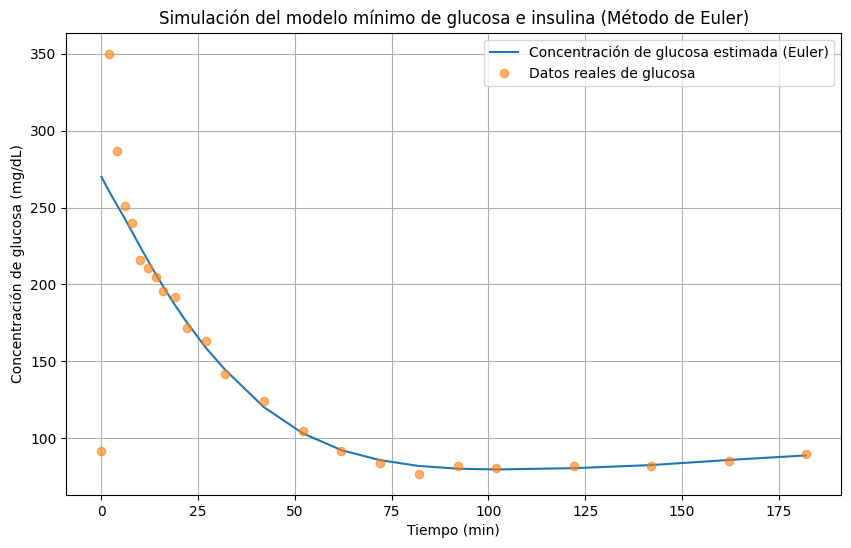

In [3]:
# APARTADO B)

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Definir las constantes dadas nuevamente
k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
Gb = glucose_data[0] # Nivel basal de glucosa
Ib = insulin_data[0]  # Nivel basal de insulina

# Condiciones iniciales
G0 = 270  # Concentración inicial de glucosa
X0 = 0    # Concentración inicial de insulina en el fluido extracelular

# Interpolar la concentración de insulina para cada minuto
I_interpolated = np.interp(time, time, insulin_data)

# Definir la función de Euler para resolver las ODEs
def solveODE_euler(f, x0, t, I_interpolated, arg=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(x[i], t[i], I_interpolated[i], *arg)
    return x

# Definir la función que representa el sistema de ecuaciones diferenciales
def sys(y, t, I, k1, k2, k3, Gb, Ib):
    G, X = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    return np.array([dGdt, dXdt])

# Definir la función de costo para el ajuste de parámetros
def cost_function(params):
    k1, k2, k3 = params
    y0 = [G0, X0]
    solution_euler = solveODE_euler(sys, y0, time, insulin_data, (k1, k2, k3, Gb, Ib))
    G_solution_euler = solution_euler[:, 0]
    return np.sum((G_solution_euler[3:] - glucose_data[3:]) ** 2)

# Definir los valores iniciales de los parámetros
initial_params = [k1, k2, k3]

# Realizar la optimización para encontrar los mejores valores de los parámetros
result = minimize(cost_function, initial_params)

# Obtener los mejores valores de los parámetros
best_params = result.x
k1_best, k2_best, k3_best = best_params

# Condiciones iniciales y constantes
y0 = [G0, X0]

# Resolver las ecuaciones utilizando el método de Euler
solution = solveODE_euler(sys, y0, time, insulin_data, (k1_best, k2_best, k3_best, Gb, Ib))

# Extraer la solución de la glucosa
G_solution = solution[:, 0]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(time, G_solution, label='Concentración de glucosa estimada (Euler)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de glucosa (mg/dL)')
plt.title('Simulación del modelo mínimo de glucosa e insulina (Método de Euler)')
plt.legend()
plt.grid(True)
plt.show()

#### Apartado c) 
 
En este apartado se introduce una nueva ecuación diferencial al modelo que describe la producción de insulina endógena al sistema.
$$ \dot{I} = -k I + \gamma (G - G_T) t, $$

Los nuevos parámetros a ajustar son:

- **k**: Tasa de eliminación de insulina.
- **γ**: Sensibilidad de la producción de insulina en función de la concentración de glucosa.
- **G_T**: Umbral de concentración de glucosa a partir del cual se empieza a generar insulina.

El objetivo es ajustar estos parámetros para que el modelo represente de la mejor forma posible los datos reales a partir de la cuarta toma de glucosa. Para ello, se emplea un método de optimización (mínimos cuadrados) que minimiza la diferencia entre la concentración simulada y los datos experimentales tanto de glucosa como de insulina.

Como se puede ver en las gráficas siguientes, el modelo inicial, y menos bruscamente el modelo ajustado, en un determinado momento en el tiempo sus valores de insulina se disparan, esto es debido a que el término $γ(G−G_T)t$ en la ecuación de insulina introduce un crecimiento dependiente del tiempo. A medida que avanza el tiempo, este término aumenta, sobre todo cuando la glucosa $G$ es mucho mayor que el umbral $G_T$, lo que provoca que la producción de insulina se dispare. En el modelo inicial, los parámetros no ajustados hacen que este efecto sea más pronunciado, causando un crecimiento descontrolado. En el modelo ajustado, aunque el disparo todavía ocurre, es menos fuerte porque los valores de $k$, $γ$ y $G_T$ se optimizan para limitar este crecimiento.

Por otra parte al usar el método "solve_ivp" de la librería "scipy", vemos que no se produce ningún cambio brusco por parte de los datos durante el tiempo sino que se ajusta correctamente a los datos, ya que utiliza algoritmos como Runge-Kutta para evaluar los cambios en las variables a lo largo del tiempo con mayor precisión.

##### Modelo con los parámetros iniciales. (Euler)

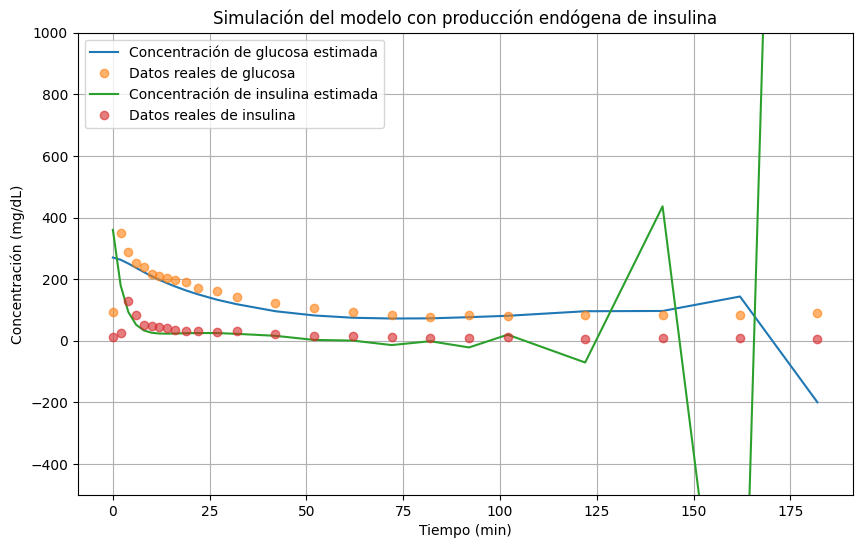

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes dadas
k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
Gb = glucose_data[0] # Nivel basal de glucosa
Ib = insulin_data[0]  # Nivel basal de insulina

# Condiciones iniciales del modelo original
G0 = 270  # Concentración inicial de glucosa
X0 = 0    # Concentración inicial de insulina en el fluido extracelular

# Nuevos parámetros para el modelo de insulina endógena
k = 0.25
gamma = 0.004
GT = 80
I0 = 360  # Nueva condición inicial para la insulina

# Definir la función de Euler para resolver las ODEs
def solveODE_euler(f, x0, t, arg=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        x[i+1] = x[i] + (t[i+1] - t[i]) * f(x[i], t[i], *arg)
    return x

# Definir la función que representa el sistema de ecuaciones diferenciales con producción endógena de insulina
def sys(y, t, k1, k2, k3, k, gamma, Gb, Ib, GT):
    G, X, I = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    dIdt = -k * I + gamma * (G - GT) * t
    return np.array([dGdt, dXdt, dIdt])

# Condiciones iniciales para G, X, I
y0 = [G0, X0, I0]

# Resolver las ecuaciones utilizando el método de Euler para el nuevo sistema
solution = solveODE_euler(sys, y0, time, (k1, k2, k3, k, gamma, Gb, Ib, GT))

# Extraer la solución de la glucosa y la insulina
G_solution = solution[:, 0]
I_solution = solution[:, 2]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.ylim(-500,1000)
plt.plot(time, G_solution, label='Concentración de glucosa estimada')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.plot(time, I_solution, label='Concentración de insulina estimada')
plt.plot(time, insulin_data, 'o', label='Datos reales de insulina', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (mg/dL)')
plt.title('Simulación del modelo con producción endógena de insulina')
plt.legend()
plt.grid(True)
plt.show()


##### Modelo con los parámetros ajustados. (Euler)

C:\Users\Acer\AppData\Local\Temp\ipykernel_27404\2665347322.py:34: RuntimeWarning: overflow encountered in double_scalars
  dGdt = -k1 * (G - Gb) - X * G
C:\Users\Acer\AppData\Local\Temp\ipykernel_27404\1434945085.py:20: RuntimeWarning: overflow encountered in square
  error_glucose = np.mean((G_solution - glucose_data)**2)
C:\Users\Acer\AppData\Local\Temp\ipykernel_27404\1434945085.py:21: RuntimeWarning: overflow encountered in square
  error_insulin = np.mean((I_solution - insulin_data)**2)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Acer\AppData\Local\Temp\ipykernel_27404\2665347322.py:34: RuntimeWarning: overflow encountered in double_scalars
  dGdt = -k1 * (G - Gb) - X * G
C:\Users\Acer\AppData\Local\Temp\ipykernel_27404\1434945085.py:20: RuntimeWarning: overflow encountered i

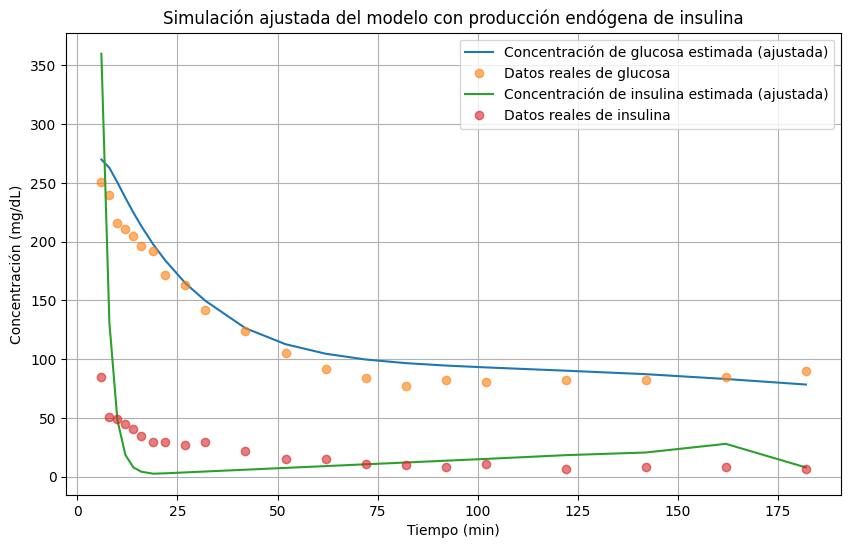

Parámetros optimizados: k = 0.31873, gamma = 7.8e-06, GT = -6195.17733


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# Seleccionar datos a partir de la cuarta toma
time = time[3:]
glucose_data = glucose_data[3:]
insulin_data = insulin_data[3:]

# Función de error para la optimización
def error_function(params, time, glucose_data, insulin_data):
    k_opt, gamma_opt, GT_opt = params
    y0_opt = [G0, X0, I0]
    # Resolver las ecuaciones con los parámetros actuales
    solution = solveODE_euler(sys, y0_opt, time, (k1, k2, k3, k_opt, gamma_opt, Gb, Ib, GT_opt))
    G_solution = solution[:, 0]
    I_solution = solution[:, 2]
    # Calcular el error cuadrático entre los datos reales y las soluciones
    error_glucose = np.mean((G_solution - glucose_data)**2)
    error_insulin = np.mean((I_solution - insulin_data)**2)
    # Error total
    return error_glucose + error_insulin

# Valores iniciales de los parámetros para la optimización
initial_params = [0.25, 0.004, 80]  # Valores iniciales de k, gamma, GT

# Realizar la optimización
result = minimize(error_function, initial_params, args=(time, glucose_data, insulin_data))

# Obtener los parámetros óptimos
k_opt, gamma_opt, GT_opt = result.x

# Condiciones iniciales para G, X, I
y0 = [G0, X0, I0]

# Resolver las ecuaciones utilizando el método de Euler con los parámetros optimizados
solution_optimized = solveODE_euler(sys, y0, time, (k1, k2, k3, k_opt, gamma_opt, Gb, Ib, GT_opt))

# Extraer la solución optimizada de la glucosa y la insulina
G_solution_optimized = solution_optimized[:, 0]
I_solution_optimized = solution_optimized[:, 2]

# Graficar los resultados después del ajuste
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_optimized, label='Concentración de glucosa estimada (ajustada)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.plot(time, I_solution_optimized, label='Concentración de insulina estimada (ajustada)')
plt.plot(time, insulin_data, 'o', label='Datos reales de insulina', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (mg/dL)')
plt.title('Simulación ajustada del modelo con producción endógena de insulina')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar los parámetros óptimos encontrados
print(f"Parámetros optimizados: k = {k_opt.round(5)}, gamma = {gamma_opt.round(7)}, GT = {GT_opt.round(5)}")


#### Modelo con los parámetros iniciales. (Solve_ivp)

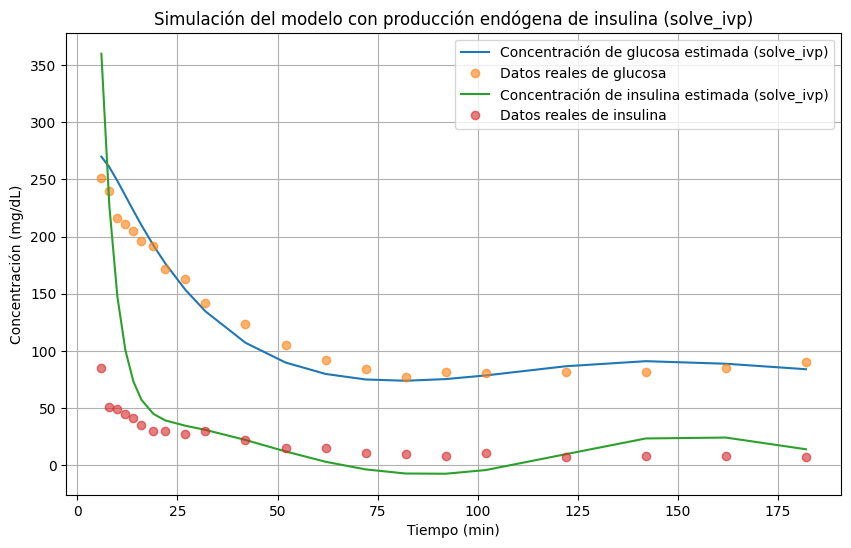

In [6]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definir la función que representa el sistema de ecuaciones diferenciales con producción endógena de insulina
def sys(t, y, k1, k2, k3, k, gamma, Gb, Ib, GT):
    G, X, I = y
    dGdt = -k1 * (G - Gb) - X * G
    dXdt = k3 * (I - Ib) - k2 * X
    dIdt = -k * I + gamma * (G - GT) * t
    return [dGdt, dXdt, dIdt]

# Condiciones iniciales para G, X, I
y0 = [G0, X0, I0]

# Usar solve_ivp para resolver las ecuaciones diferenciales en lugar de Euler
solution_ivp = solve_ivp(sys, [time[0], time[-1]], y0, t_eval=time, args=(k1, k2, k3, k, gamma, Gb, Ib, GT))

# Extraer la solución de la glucosa y la insulina
G_solution_ivp = solution_ivp.y[0]
I_solution_ivp = solution_ivp.y[2]

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_ivp, label='Concentración de glucosa estimada (solve_ivp)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.plot(time, I_solution_ivp, label='Concentración de insulina estimada (solve_ivp)')
plt.plot(time, insulin_data, 'o', label='Datos reales de insulina', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (mg/dL)')
plt.title('Simulación del modelo con producción endógena de insulina (solve_ivp)')
plt.legend()
plt.grid(True)
plt.show()



#### Modelo con los parámetros ajustados. (Solve_ivp)

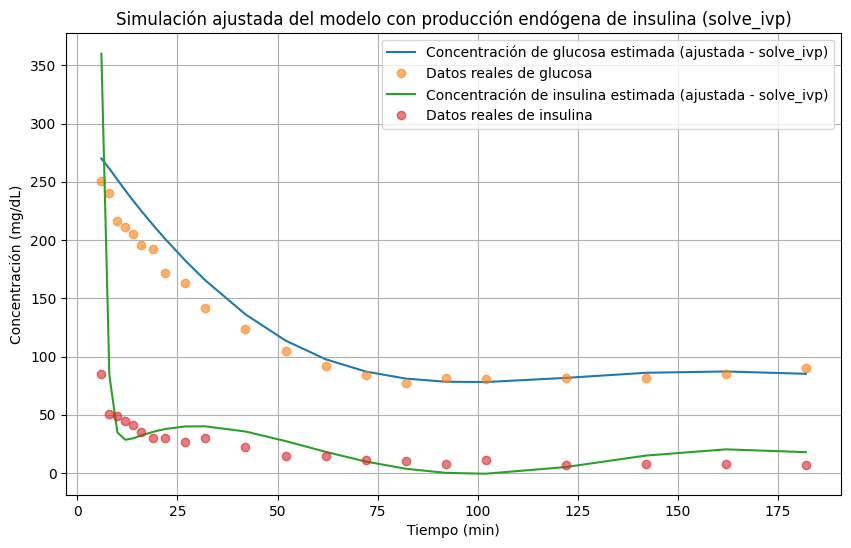

Parámetros optimizados (solve_ivp): k = 0.83423, gamma = 0.0119862, GT = 78.45693


In [7]:
# Ajustar las dimensiones en el cálculo del error para que coincidan con los datos ajustados
def error_function_ivp(params, time, glucose_data, insulin_data):
    k_opt, gamma_opt, GT_opt = params
    y0_opt = [G0, X0, I0]
    # Resolver las ecuaciones con solve_ivp en lugar de Euler
    solution_ivp = solve_ivp(sys, [time[0], time[-1]], y0_opt, t_eval=time, args=(k1, k2, k3, k_opt, gamma_opt, Gb, Ib, GT_opt))
    G_solution = solution_ivp.y[0]
    I_solution = solution_ivp.y[2]
    # Ajustar las dimensiones de los datos de glucosa e insulina
    glucose_data = glucose_data[:len(G_solution)]
    insulin_data = insulin_data[:len(I_solution)]
    # Calcular el error cuadrático entre los datos reales y las soluciones
    error_glucose = np.mean((G_solution - glucose_data)**2)
    error_insulin = np.mean((I_solution - insulin_data)**2)
    # Error total
    return error_glucose + error_insulin

# Realizar nuevamente la optimización con las dimensiones ajustadas
result_ivp = minimize(error_function_ivp, initial_params, args=(time, glucose_data, insulin_data))

# Obtener los parámetros óptimos
k_opt, gamma_opt, GT_opt = result_ivp.x

# Condiciones iniciales para G, X, I con los parámetros optimizados
y0_optimized = [G0, X0, I0]

# Resolver las ecuaciones utilizando solve_ivp con los parámetros optimizados
solution_optimized_ivp = solve_ivp(sys, [time[0], time[-1]], y0_optimized, t_eval=time, args=(k1, k2, k3, k_opt, gamma_opt, Gb, Ib, GT_opt))

# Extraer la solución optimizada de la glucosa y la insulina
G_solution_optimized_ivp = solution_optimized_ivp.y[0]
I_solution_optimized_ivp = solution_optimized_ivp.y[2]

# Graficar los resultados después del ajuste utilizando solve_ivp
plt.figure(figsize=(10,6))
plt.plot(time, G_solution_optimized_ivp, label='Concentración de glucosa estimada (ajustada - solve_ivp)')
plt.plot(time, glucose_data, 'o', label='Datos reales de glucosa', alpha=0.6)
plt.plot(time, I_solution_optimized_ivp, label='Concentración de insulina estimada (ajustada - solve_ivp)')
plt.plot(time, insulin_data, 'o', label='Datos reales de insulina', alpha=0.6)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (mg/dL)')
plt.title('Simulación ajustada del modelo con producción endógena de insulina (solve_ivp)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar los parámetros óptimos encontrados
print(f"Parámetros optimizados (solve_ivp): k = {k_opt.round(5)}, gamma = {gamma_opt.round(7)}, GT = {GT_opt.round(5)}")


#### Apartado d)



Ambas medidas biológicas están fuera de los rangos esperados, lo que indica que el ajuste del modelo, a pesar de minimizar los errores, no está alineado con las expectativas de los autores de la respuesta insulina-glucosa.

In [8]:
from scipy.optimize import minimize

# Calcular los valores de phi_1 y phi_2 basados en los parámetros optimizados
I_max = insulin_data.max()
phi_1 = (I_max - Ib) / (k_opt * (G0 - Gb))
phi_2 =  gamma_opt * 10**4

phi_1, phi_2


(0.4983425094594572, 119.86201021518454)

## Ejercicio 2

El oscilador de Van der Pol es un sistema dinámico creado alrededor de 1926 que consiste en un circuito eléctrico con realimentaciones positivas y resistores no lineales. El circuito, tal como se diseñó, favorece oscilaciones pequeñas y amortigua las grandes. Una extensión de estos sistemas se ha aplicado en Medicina para simular el proceso de un marcapasos. Un interesante resumen de la historia y análisis matemático del oscilador de Van der Pol lo pueden encontrar en el trabajo de [Casaico-Suárez et al. (1920)](https://www.researchgate.net/publication/344507421_El_Oscilador_de_Van_Der_Pol).

Aplicando las leyes físicas al circuito eléctrico de Van der Pol, se llega a la siguiente ecuación: 

$$\ddot{x} -\mu (1-x^2) \dot{x} +x =0,$$

donde $x$ es una combinación de las variables eléctricas del sistema (intensidad, voltaje, etc.) y $\mu$ es un parámetro de control de la resistencia. 

**a)** Simular el sistema de orden 2 para las condiciones iniciales $x(0)=0.5$, $\dot{x}(0)=0.5$ y $\mu=1$. Para ello escribir el modelo como un sistema de ecuaciones diferenciales de dos variables $x$ e $y$, con $y= \dot{x}$. Realizar la gráfica de la trayectoria de la variable $x$ y el diagrama de fases $(x,y)$. 

**b)** Hallar los puntos de equilibrio del sistema y los valores propios del sistema en función de $\mu$. Determinar valores de $\mu$ donde los valores propios cambian de signo y/o la parte imaginaria del valor propio pasa de nula a no nula o viceversa. 

**c)** Simular el modelo para valores de $\mu$ dentro de los diversos rangos definidos por los valores calculados en el apartado **b)**. Tomar distintas condiciones iniciales. 

#### Apartado a)

Para resolver esta ecuación de segundo orden, la vamos a reescribir como un sistema de dos ecuaciones diferenciales de primer orden. Si definimos:
$𝑦=𝑥˙$
 , entonces el sistema se convierte en:
 
$$\dot{𝑥}=𝑦$$

$$\dot{y}=μ(1−x^2)y−x$$

El método Runge-Kutta de cuarto orden (RK4) se utiliza en lugar de Euler porque es mucho más preciso y estable, especialmente en sistemas no lineales como el oscilador de Van der Pol. RK4 captura mejor las oscilaciones complejas y evita los errores acumulativos y la inestabilidad que Euler puede generar en valores grandes de $\mu$.

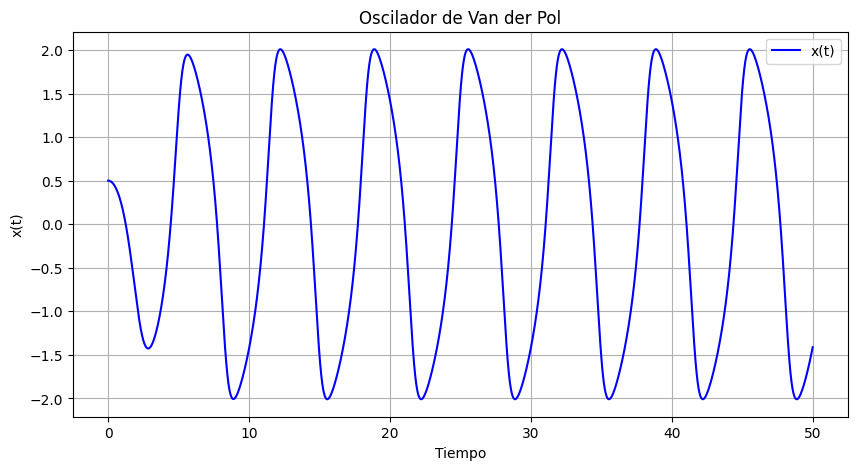

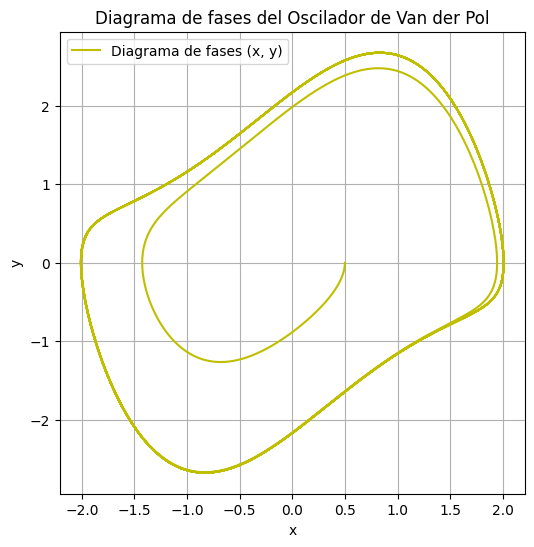

In [9]:
import numpy as np
import matplotlib.pyplot as plt

initial_state = [0.5, 0]
x_star0 = 0.5
mu = 1
t_span = [0, 50]  
t_eval = np.linspace(t_span[0], t_span[1], 10000)  

# Sistema de Van der Pol (convertido en sistema de primer orden)
def sys(t, x, mu):
    x, y = x
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]

def solveODE_RK4(f, x0, t, args=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], x[i], *args)
        k2 = f(t[i] + h / 2., x[i] + h / 2. * np.array(k1), *args)
        k3 = f(t[i] + h / 2., x[i] + h / 2. * np.array(k2), *args)
        k4 = f(t[i] + h, x[i] + h * np.array(k3), *args)
        x[i+1] = x[i] + (h / 6.) * (np.array(k1) + 2*np.array(k2) + 2*np.array(k3) + np.array(k4))
    return x

sol = solveODE_RK4(sys, initial_state, t_eval, args=(mu,))

# Graficar la trayectoria de x en función del tiempo
plt.figure(figsize=(10, 5))
plt.plot(t_eval, sol[:, 0], label='x(t)', color='b')
plt.xlabel('Tiempo')
plt.ylabel('x(t)')
plt.title('Oscilador de Van der Pol')
plt.grid(True)
plt.legend()

# Graficar el diagrama de fases (x, y)
plt.figure(figsize=(6, 6))
plt.plot(sol[:, 0], sol[:, 1], label='Diagrama de fases (x, y)', color='y')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Diagrama de fases del Oscilador de Van der Pol')
plt.grid(True)
plt.legend()

plt.show()



#### Apartado b)

Los puntos de equilibrio son los valores de $x$ $y$ que hacen que $\dot{x}=0$ y $\dot{y}=0$. Esto implica resolver el sistema:

$$y=0$$

$$μ(1−x^2)y−x=0$$

Sustituyendo $y=0$ en la segunda ecuación:

$$−x=0$$

Esto implica que el único punto de equilibrio es:

$$(x,y)=(0,0)$$

Para hallar los valores propios del sistema, se linealiza el sistema alrededor del punto de equilibrio. Para ello, se define la matriz jacobiana del sistema. El Jacobiano se calcula tomando las derivadas parciales de cada ecuación con respecto a $x$ $y$. En este caso, el Jacobiano es:

$$J=\begin{bmatrix}0 & 1\\-1 & μ\end{bmatrix}$$

Para determinar la estabilidad del sistema, debemos calcular los valores propios del Jacobiano. Los valores propios $\lambda$ se encuentran resolviendo el determinante de $J−\lambda I=0$. En este caso, el determinante es:

$$det(\begin{bmatrix}-\lambda & 1\\-1 & \mu - \lambda \end{bmatrix})=0$$

Resolviendo la ecuación anterior, se obtiene que los valores propios son:

$$\lambda=\frac{μ±\sqrt{μ^2-4}}{2}$$

En conclusión, cuando $\mu^2<4$ los valores propios tienen una parte imaginaria y el sistema tiene un comportamiento oscilatorio. Por otro lado, cuando $\mu^2>4$ los valores propios son reales y el sistema tiene un comportamiento estable. Cuando $\mu^2=4$ los valores propios se encuentran en un punto crítico y el sistema está en el límite entre comportamiento oscilatorio y estable. Por lo tanto, en los valores $\mu=±2$ los valores propios pasan de tener una parte imaginaria a ser puramente reales, o viceversa.

Para saber cuándo los valores propios cambian de signo, nos fijamos en la parte real, que es:

$$\frac{μ}{2}$$

Por tanto si $\mu > 0$ los valores propios son positivos y si $\mu < 0$ los valores propios son negativos. Entonces los valores propios cambian de signo en $\mu=0$.

#### Apartado c)

Para simular el modelo para valores de $\mu$ dentro de los diversos rangos definidos por los valores calculados en el apartado **b)**, se puede utilizar la función `solve_ivp` de la librería `scipy.integrate`. Para ello, se debe definir una función que devuelva las derivadas de las variables $x$ e $y$ en función de $x$ e $y$ y el parámetro $\mu$. A continuación, se muestra un ejemplo de cómo se puede realizar la simulación para un valor de $\mu$:

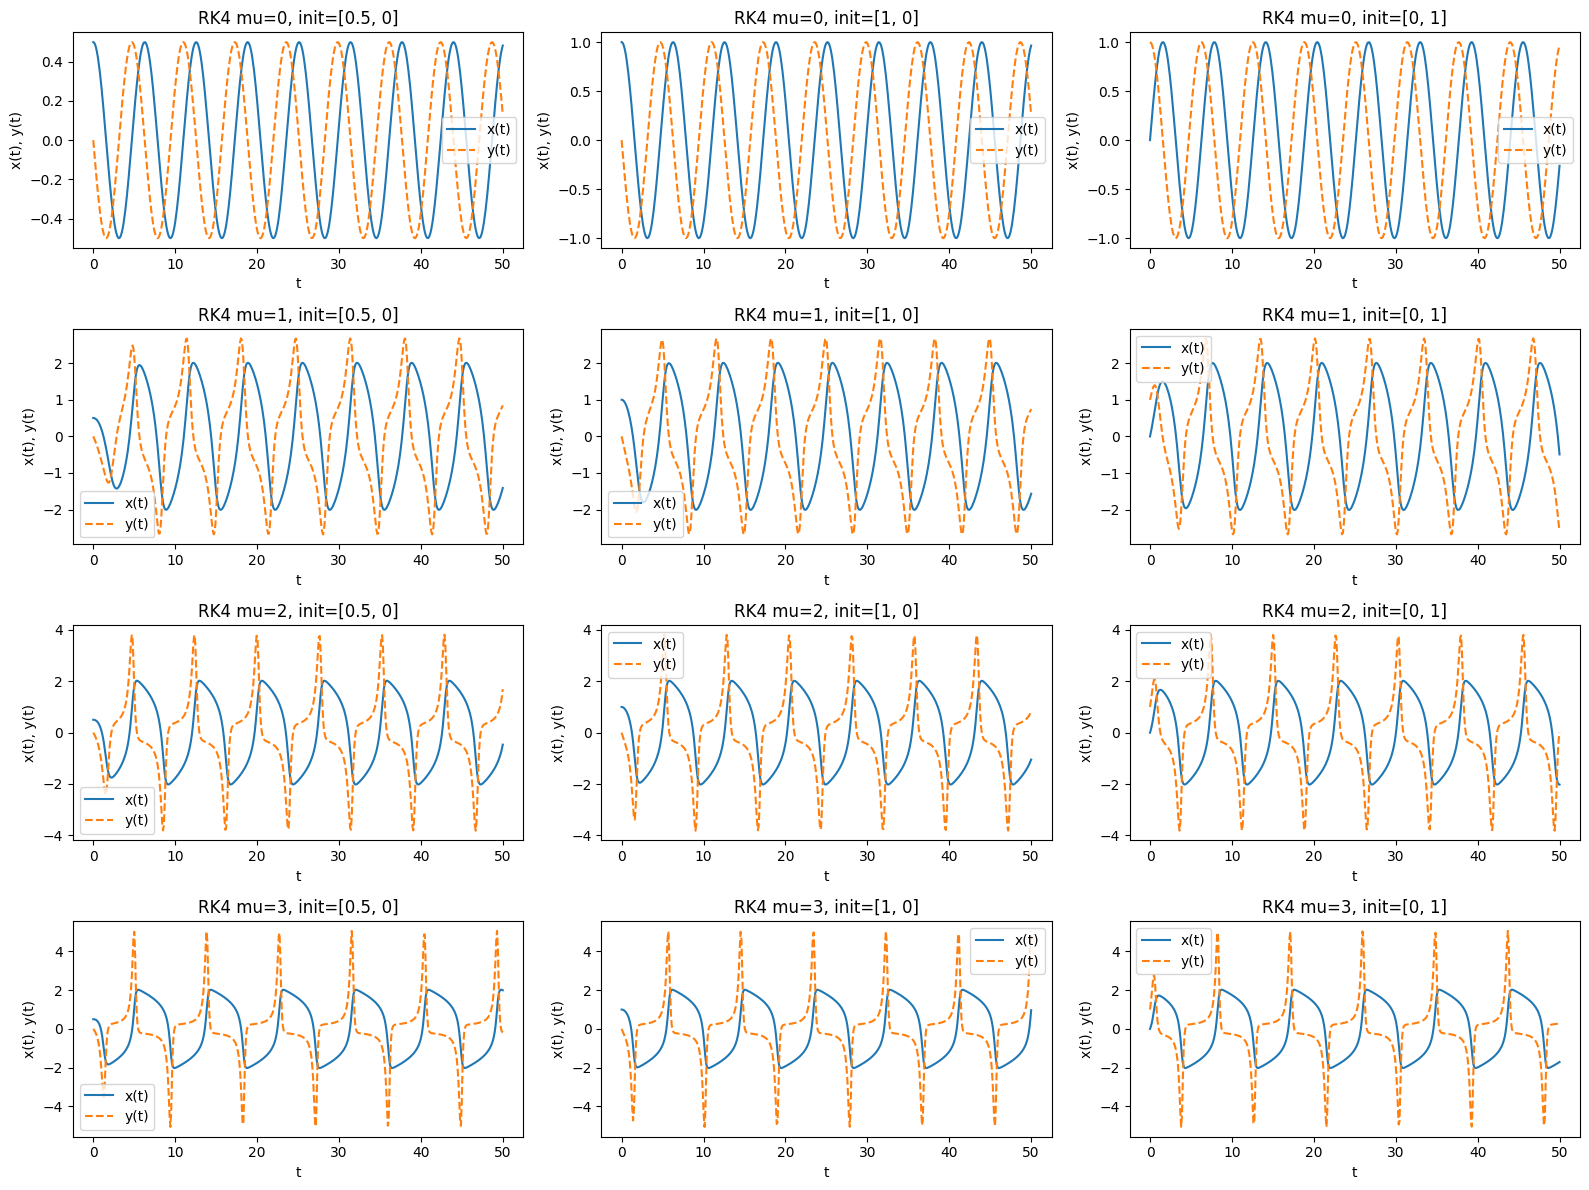

In [10]:
import numpy as np
import matplotlib.pyplot as plt


initial_conditions = [
    [0.5, 0],  
    [1, 0],    
    [0, 1],    
]

mu_values_simulation = [0, 1, 2, 3]
t_eval = np.linspace(0, 50, 500)
euler_results = []  

# Sistema de Van der Pol (convertido en sistema de primer orden)
def sys(t, x, mu):
    x, y = x
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]

def solveODE_RK4(f, x0, t, args=()):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], x[i], *args)
        k2 = f(t[i] + h / 2., x[i] + h / 2. * np.array(k1), *args)
        k3 = f(t[i] + h / 2., x[i] + h / 2. * np.array(k2), *args)
        k4 = f(t[i] + h, x[i] + h * np.array(k3), *args)
        x[i+1] = x[i] + (h / 6.) * (np.array(k1) + 2*np.array(k2) + 2*np.array(k3) + np.array(k4))
    return x

for mu in mu_values_simulation:
    for initial in initial_conditions:
        sol_rk4 = solveODE_RK4(sys, initial, t_eval, args=(mu,))
        euler_results.append((mu, initial, t_eval, sol_rk4))

plt.figure(figsize=(16, 12))

for i, (mu, initial, t, y) in enumerate(euler_results):
    plt.subplot(4, 3, i + 1)
    plt.plot(t, y[:, 0], label=f"x(t)")
    plt.plot(t, y[:, 1], label=f"y(t)", linestyle="--")
    plt.title(f"RK4 mu={mu}, init={initial}")
    plt.xlabel("t")
    plt.ylabel("x(t), y(t)")
    plt.legend()

plt.tight_layout()
plt.show()



$\mu=0$: El sistema es casi lineal, con oscilaciones suaves, reflejando que los valores propios no tienen parte imaginaria, y la parte real es cero.

$\mu=1$: Comienzan a aparecer oscilaciones no lineales, ya que los valores propios tienen una parte imaginaria, pero aún hay un comportamiento oscilatorio controlado.

$\mu=2$: Punto crítico donde los valores propios cambian de ser complejos a reales. Las oscilaciones se vuelven más amplificadas y no lineales.

$\mu=3$: El sistema es altamente no lineal, con oscilaciones grandes, debido a que los valores propios son puramente reales y dominan el comportamiento.

## Ejercicio 3

En 1963, el meteorólogo E. Lorenz propuso un modelo que representa la convección de un fluido en los lados de columnas hexagonales. Las ecuaciones del modelo son las siguientes: 

$$ \begin{array}{l} \dot{x} = \sigma (y-z), \\ \dot{y} = rx -y-xz, \\ \dot{z} = xy-bz, \end{array}$$

donde $x$ mide la tasa de vuelco convectivo, $y$ la variación de temperatura horizontal y $z$ la variación de temperatura vertical.Los parámetros $\sigma$, $r$ y $b$ representan constantes relacionadas con la viscosidad del fluido y diferencias de temperatura. 

El modelo representa de forma muy simplificada el sistema del clima. Por tanto, la complejidad de las soluciones de este modelo ilustra la tremenda complejidad del clima real. Más detalles en [Lorenz (1963)](https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml)

**(a)** Simular el modelo y representar las trayectorias de $x(t)$ y el diagrama de fases tridimensional $(x,y,z)$. Tomar como condición inicial $x(0) = 10$, $y(0) = z(0) = 5$, y valores de los parámetros $\sigma=10$, $b=8/3$. Tomar valores de $r$ en el conjunto $\{5, 12, 20, 28\}$. Determinar con la simulación el comportamiento asintótico de las variables. 

**(b)** Comprobar la sensibilidad de los resultados del modelo a las condiciones iniciales en los tres primeros valores de $r$ (5, 12, 20). Esto es, dado $x_\epsilon$ las solución del modelo con $x_\epsilon(0)=x(0)+\epsilon$ y $T$ un tiempo suficientemente alto, se trata de estudiar la diferencia $x(T)-x_\epsilon(T)$ en función de $\epsilon$. Debe converger a cero para $\epsilon \rightarrow 0$.

**(c)** La figura observada en el diagrama de fases en el caso $r=28$ se denomina 'Atractor de Lorenz'. Es una figura en general estable para valores de $r>25$ (comprobar). Comprobar la sensibilidad del modelo a las condiciones iniciales para $r=28$ (o cualquier otro que presente el atractor de Lorenz).  

#### Apartado a)

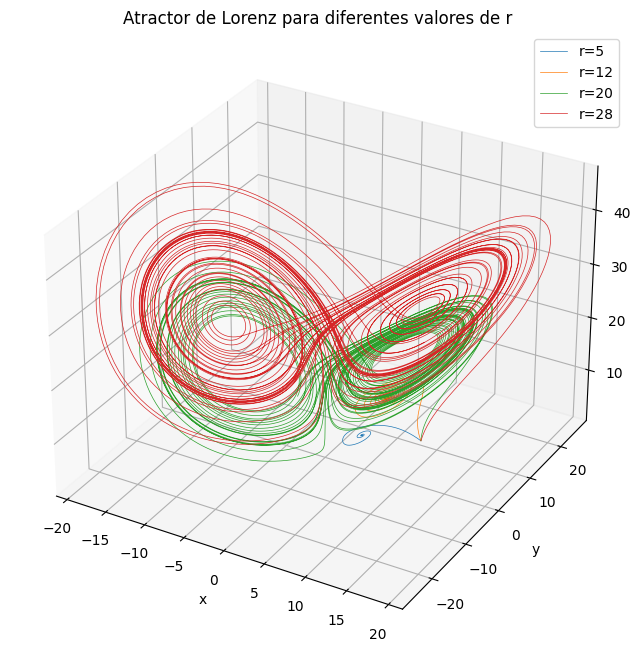

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros
sigma = 10
b = 8/3
r = [5, 12, 20, 28]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = [0, 50]  # Tiempo
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Tiempo evaluado

# Crear una figura y un conjunto de ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], label=f'r={r_value}', lw=0.5)

# Personalizar el gráfico
ax.set_title('Atractor de Lorenz para diferentes valores de r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Mostrar el gráfico
plt.show()


#### Apartado b)

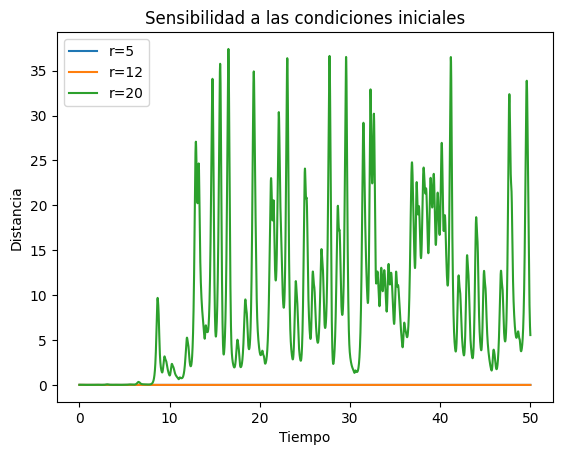

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
sigma = 10
b = 8/3
r = [5, 12, 20]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = 50  # Tiempo
t_eval = np.linspace(0, t_span, 10000)  # Tiempo evaluado
epsilon = 0.01 # Perturbación en las condiciones iniciales

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))

    # Solución con condiciones iniciales perturbadas en x(0) + epsilon
    perturbed_state = [initial_state[0] + epsilon, initial_state[1], initial_state[2]]
    sol_perturbed = solveODE_euler(sys, perturbed_state, t_eval, args=(sigma, r_value, b))

    # Distancia euclidiana entre las soluciones
    distance = np.linalg.norm(sol - sol_perturbed, axis=1)
    plt.plot(t_eval, distance, label=f'r={r_value}')  # Distancia vs tiempo

plt.xlabel('Tiempo')
plt.ylabel('Distancia')
plt.title('Sensibilidad a las condiciones iniciales')
plt.legend()
plt.show()


En el gráfico, se puede observar cómo la diferencia entre las trayectorias $x(T)$ y $xϵ(T)$ varía en función del tiempo para los tres valores de $r$ (5, 12, 20). Los resultados muestran que:

Para $r=5$ y $r=12$, la diferencia entre las trayectorias permanece cercana a cero, indicando que el sistema no es particularmente sensible a pequeñas perturbaciones en las condiciones iniciales.

Para $r=20$, la diferencia crece rápidamente y se vuelve oscilatoria, lo que indica un comportamiento mucho más caótico y una alta sensibilidad a las condiciones iniciales.

Este comportamiento es característico de sistemas caóticos como el de Lorenz, donde pequeños cambios en las condiciones iniciales pueden llevar a trayectorias completamente diferentes con el tiempo, especialmente para valores de $r$ que generan dinámica caótica, como $r=20$.

#### Apartado c)

Utiliazamos el mismo código que en el apartado A) pero esta vez usando valores de $r$ mayores a 25 para comprobar su estabilidad.

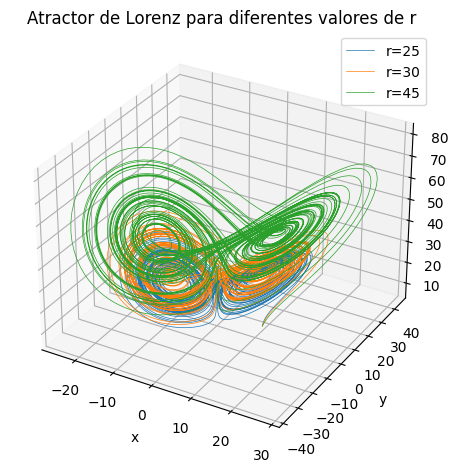

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros
sigma = 10
b = 8/3
r = [25, 30, 45]
initial_state = [10, 5, 5]  # x(0), y(0), z(0)

# Sistema de Lorenz
def sys(t, state, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = r * x - y - x * z
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# Método de Euler modificado para manejar sistemas de ecuaciones
def solveODE_euler(f, x0, t, args=()):
    n = len(t)
    dim = len(x0)
    x = np.zeros((n, dim))  # Matriz para almacenar las soluciones (n x 3)
    x[0] = x0  # Condiciones iniciales
    for i in range(n - 1):
        dxdt = f(t[i], x[i], *args)  # Derivadas
        x[i+1] = x[i] + (t[i+1] - t[i]) * np.array(dxdt)  # Aproximación por Euler
    return x

# Intervalo de tiempo y puntos de evaluación
t_span = [0, 50]  # Tiempo
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Tiempo evaluado

# Graficar el atractor de Lorenz (trayectoria original)
fig = plt.figure(figsize=(12, 6))

# Diagrama de fases tridimensional (Atractor de Lorenz)
ax = fig.add_subplot(121, projection='3d')

# Simulación para diferentes valores de r
for r_value in r:
    sol = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r_value, b))
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], label=f'r={r_value}', lw=0.5)

# Personalizar el gráfico
ax.set_title('Atractor de Lorenz para diferentes valores de r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Mostrar el gráfico
plt.show()


A continuación, simulamos el modelo para $r=28$ y comprobamos la sensibilidad del modelo a las condiciones iniciales.

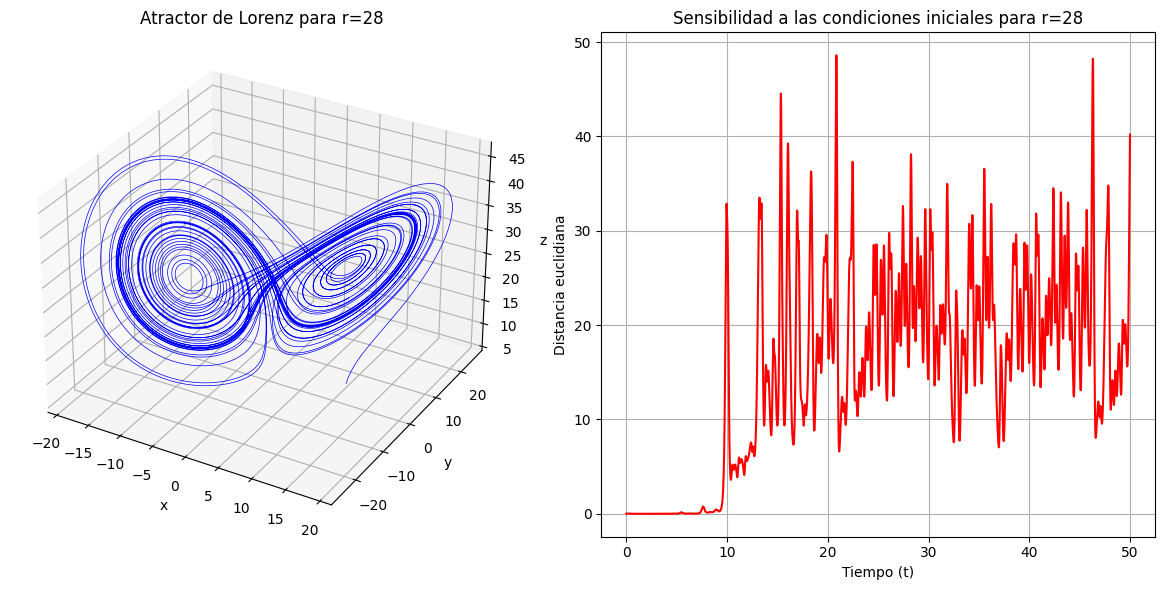

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Parámetros para r = 28
sigma = 10
b = 8/3
r = 28
initial_state = [10, 5, 5]  # x(0), y(0), z(0)
epsilon = 0.01  # Perturbación inicial
T = 50  # Tiempo máximo de simulación
t_eval = np.linspace(0, T, 10000)  # Tiempo evaluado

# Solución con condiciones iniciales originales
sol_original = solveODE_euler(sys, initial_state, t_eval, args=(sigma, r, b))

# Solución con condiciones iniciales perturbadas en x(0) + epsilon
perturbed_state = [initial_state[0] + epsilon, initial_state[1], initial_state[2]]
sol_perturbed = solveODE_euler(sys, perturbed_state, t_eval, args=(sigma, r, b))

# Calcular la distancia euclidiana entre las soluciones en todas las coordenadas
distance = np.linalg.norm(sol_original - sol_perturbed, axis=1)

# Graficar el atractor de Lorenz (trayectoria original)
fig = plt.figure(figsize=(12, 6))

# Diagrama de fases tridimensional (Atractor de Lorenz)
ax = fig.add_subplot(121, projection='3d')
ax.plot(sol_original[:, 0], sol_original[:, 1], sol_original[:, 2], color='b', lw=0.5)
ax.set_title('Atractor de Lorenz para r=28')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Graficar la distancia euclidiana entre las trayectorias
plt.subplot(122)
plt.plot(t_eval, distance, color='r')
plt.xlabel('Tiempo (t)')
plt.ylabel('Distancia euclidiana')
plt.title('Sensibilidad a las condiciones iniciales para r=28')
plt.grid(True)

plt.tight_layout()
plt.show()


Para $r=28$, observamos el clásico Atractor de Lorenz, una figura compleja y caótica. Es estable en el sentido de que el sistema siempre termina acercándose a esta figura en el espacio de fases, pero las trayectorias son caóticas dentro de esta región.

El gráfico de la derecha muestra cómo la distancia euclidiana entre las trayectorias perturbadas y las trayectorias originales evoluciona con el tiempo. Como se puede ver, pequeñas diferencias en las condiciones iniciales ($ϵ=0.01$) resultan en grandes diferencias en las trayectorias a medida que el tiempo avanza, lo que es un signo claro de la naturaleza caótica del sistema.